In [1]:
%run init.ipy

from lib import constants
from lib import klatt

## Get some test data from VTRFormants ***TEST*** set

In [2]:
import random
from vtr.prior import formant
from lib import timit

def rand_triple():
    vtr_root = timit.test_set(timit.VTRFORMANTS)
    timit_root = timit.test_set(timit.TIMIT)
    l = list(timit.yield_file_triples(vtr_root, timit_root))
    return random.choice(l)

fb_file, phn_file, wav_file = rand_triple()

2023-01-03 15:51:23.735914: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-03 15:51:23.735965: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-01-03 15:51:23.735969: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## Test noise sigma prior

Test the noise sigma prior (bijector). We put a mean at -20 dB and floor it at the noise floor. Relative uncertainty is 100% leading to a nois power dB of roughly -20 +/- 7.5 dB.

(-21.09222288857734, 7.485871368776038)

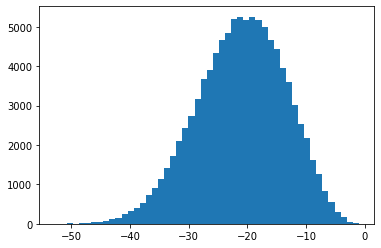

In [3]:
from inv import model

b = model.noise_sigma_bijector()

noise_sigmas = b.forward(randn(100000))

noise_power_dbs = 20*np.log10(noise_sigmas)

hist(noise_power_dbs, bins=50);

np.mean(noise_power_dbs), np.std(noise_power_dbs)

## Test model with random hyper priors

NP = 2
Number of data points: 57
Number of model dimensions: 34


({'kernel_name': 'Matern32Kernel',
  'kernel_M': 128,
  'use_oq': True,
  'impose_null_integral': False},
 PoleZeroFilter(3))

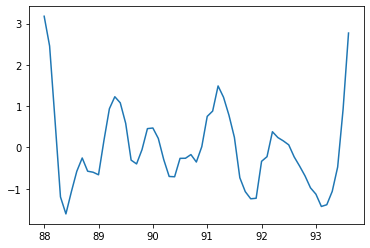

In [23]:
from inv import process
from vtr.prior import filter

source_config = dict(
    kernel_name = "Matern32Kernel",
    kernel_M = 128,
    use_oq = True,
    impose_null_integral = False
)

vtfilter = filter.PZ(3, numpy_backend=jax.numpy, scipy_backend=jax.scipy)

hyper = process.make_rand_hyper(
    (fb_file, phn_file, wav_file),
    source_config = source_config,
    vtfilter = vtfilter,
    process_data_kwargs=dict(max_NP = 2, prepend=1)
)

plot(hyper['data']['t'], hyper['data']['d'])
print("NP =", hyper['data']['NP'])
print("Number of data points:", len(hyper['data']['d']))
print("Number of model dimensions:", model.ndim(hyper))

display(klatt.play(hyper['data']['t'], hyper['data']['d']))

hyper['source'], hyper['filter']

In [24]:
prior = model.theta_trajectory_prior(hyper)
theta = prior.sample(seed=jaxkey())
theta, prior.log_prob(theta)

[Memory]498.3s, 8.3min  : Loading posterior_of_fitted_lf_values...
[Memory]498.3s, 8.3min  : Loading run_nested...
[Memory]498.4s, 8.3min  : Loading posterior_of_fitted_TFB_values...
[Memory]498.4s, 8.3min  : Loading run_nested...


({'noise_sigma': DeviceArray(0.13937839, dtype=float64),
  'delta': DeviceArray(0.38715163, dtype=float64),
  'source': DeviceArray([[0.89611955, 0.05790923, 6.10418957, 0.97348607],
               [0.86492637, 0.06477065, 5.88178286, 0.98285298]],            dtype=float64),
  'filter': DeviceArray([[ 464.31321661, 1620.63702854, 2650.6220783 ,   54.86365177,
                 271.92594093, 1174.02239798],
               [ 445.55736034, 1576.67002031, 2593.24312629,   53.12121472,
                 301.88527979, 1239.70551048]], dtype=float64),
  'g': DeviceArray([[ 0.67917968, -1.70518367,  1.10406035, -1.31824202,
                -0.26246744, -0.67365483],
               [-0.62689719,  1.63303151,  0.39884653, -1.42329523,
                 0.15499797,  0.84975392]], dtype=float64)},
 DeviceArray(-80.08148982, dtype=float64))

In [25]:
def curry(theta):
    return model.full_likelihood(theta, hyper)

curry(theta), model.unpack_theta(jax.jit(jax.grad(curry))(theta), hyper)

(DeviceArray(-98.60452457, dtype=float64),
 (DeviceArray(130.002448, dtype=float64),
  DeviceArray(194.11879805, dtype=float64),
  {'Oq': DeviceArray([  -9.98194014, -124.26935292], dtype=float64),
   'T': DeviceArray([  -1.59190332, -140.18264714], dtype=float64),
   'r': DeviceArray([ -118.98125396, -1201.59261132], dtype=float64),
   'var_sigma': DeviceArray([ 34.22237444, 176.36665184], dtype=float64)},
  {'g': DeviceArray([[ -3.10720189, -15.12990412,   5.63286121,  -5.17391917,
                   6.99880825,   6.27044483],
                [-22.22032584,  40.18259628,  14.09829413, -33.5224253 ,
                  42.27715917,  15.42402389]], dtype=float64),
   'x': DeviceArray([[ 0.08271898, -0.03504599, -0.00678125],
                [ 0.07393292, -0.09657824,  0.00179114]], dtype=float64),
   'y': DeviceArray([[-0.00197492, -0.02528679,  0.0010703 ],
                [ 0.64199329,  0.02094693,  0.00384784]], dtype=float64)}))

Show the possible model functions $f(t;\theta)$ for a sampled $\theta$. We need to find a $\theta$ for which **most** -- not just a few -- of these samples are close to the data. **This is Bayesian regularization in action.**

We can see that the general amplitude magnitude is reasonable, although for larger $K$ for PZ and $N_P$ it may take more samples to hit O(1) range. This is because of interpitch-period correlations and the heavier tails of the energy distribution of the PZ model.

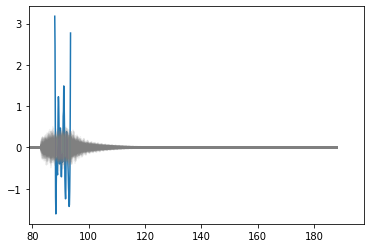

In [26]:
theta = prior.sample(seed=jaxkey())
noise_sigma, delta, theta_source, theta_filter = model.unpack_theta(theta, hyper)

hyper2 = process.hyper_fullt(hyper)

R = model.full_kernelmatrix_root(
    delta, theta_source, theta_filter, hyper2, convolve=True
)

plot(hyper['data']['t'], hyper['data']['d'])

nsamp = 100
for _ in range(nsamp):
    w = model.randf(hyper)
    f = R @ w
    plot(hyper['data']['fullt'], f, color='grey', alpha=1/sqrt(nsamp))

def setxlim(f, margin=0.05):
    ts = hyper['data']['fullt'][f != 0.]
    xlim(ts[0]*(1-margin), ts[-1]*(1+margin))

setxlim(f)

klatt.play(hyper['data']['t'], f)

We can see the correlations in the $f$ amplitudes well.

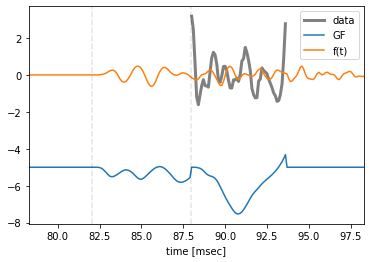

In [27]:
theta = prior.sample(seed=jaxkey())
delta, noise_sigma, theta_source, theta_filter = model.unpack_theta(theta, hyper)
offset = model.get_offset(delta, theta_source, hyper)

hyper2 = process.hyper_fullt(hyper)

R = model.full_kernelmatrix_root(
    delta, theta_source, theta_filter, hyper2, convolve=True
)

R_gfd = model.full_kernelmatrix_root(
    delta, theta_source, theta_filter, hyper2, convolve=False, integrate=True
)

w = model.randf(hyper)

plot(hyper['data']['t'], hyper['data']['d'], color="grey", label="data", lw=3)

plot(hyper['data']['fullt'], R_gfd @ w - 5, label="GF")
plot(hyper['data']['fullt'], R @ w, label="f(t)")
for tp in offset: axvline(tp, ls="--", color="black", alpha=.1)
xlabel("time [msec]")
setxlim(R_gfd @ w)
legend();

## Try NS with gradient

In [28]:
import tensorflow_probability.substrates.jax.bijectors as tfb
def theta_trajectory_bijector_unit_cube(hyper):
    return tfb.Chain([
        model.theta_trajectory_bijector(hyper), tfb.Invert(tfb.NormalCDF())
    ])

In [29]:
import dynesty
import scipy

theta_bijector_unit = theta_trajectory_bijector_unit_cube(hyper)

@jax.jit
def loglike(u):
    theta = theta_bijector_unit.forward(u)
    logl = model.full_likelihood(theta, hyper)
    return logl

ptform = lambda x: x

grad_u = jax.jit(jax.grad(loglike))

ndim = model.ndim(hyper)

[Memory]505.4s, 8.4min  : Loading posterior_of_fitted_lf_values...
[Memory]505.4s, 8.4min  : Loading run_nested...
[Memory]505.4s, 8.4min  : Loading posterior_of_fitted_TFB_values...
[Memory]505.4s, 8.4min  : Loading run_nested...


In [30]:
loglike(rand(model.ndim(hyper)))

DeviceArray(-1377.14856931, dtype=float64)

In [31]:
grad_u(rand(model.ndim(hyper)))

DeviceArray([ 3.44958885e+03, -4.66927366e+03, -4.63799734e+02,
             -6.89103778e+01, -5.32079894e+03, -1.70282769e+02,
              9.74102790e+02,  1.00886883e+03,  7.18546114e+00,
              2.72033210e+00, -4.10706117e+02, -1.17154397e+00,
             -5.54390953e+02, -5.73552962e+01, -7.69590520e+02,
             -4.59208965e+02,  3.38916120e+02,  2.18941311e+01,
             -1.01478478e+02, -3.34887027e+00,  1.12186112e+02,
              1.14872357e+01, -1.20188294e+02,  4.94810066e+01,
             -1.77452472e+02, -4.08433205e+02, -1.80508101e+01,
             -4.17980110e+01,  8.12550745e+03,  4.81525336e+02,
             -1.54030840e+02, -6.23993774e+02,  3.82009534e+02,
              4.44116669e+02], dtype=float64)

In [42]:
SAMPLERARGS = {'sample': 'hslice', 'gradient': grad_u, 'first_update': {'min_eff': 2.}}
RUNARGS = {'save_bounds': False, 'maxcall': int(1e5)}

sampler = dynesty.NestedSampler(
    loglike, ptform, ndim, nlive=ndim*3, **SAMPLERARGS
)

sampler.run_nested(**RUNARGS)
results = sampler.results

590it [01:06,  8.83it/s, bound: 1 | nc: 1393 | ncall: 55843 | eff(%):  1.057 | loglstar:   -inf < -63.975 <    inf | logz: -72.174 +/-  0.262 | dlogz: 29.357 >  0.111]


KeyboardInterrupt: 

In [ ]:
model.unpack_theta(theta_bijector_unit.forward(results.samples[-1,:]), hyper)

## Try MAP from unit cube

In [43]:
import jaxopt

theta_bijector_unit = theta_trajectory_bijector_unit_cube(hyper)

ndim = model.ndim(hyper)
print(ndim)

def logabsdet_delw_deltheta(w):
    return -theta_bijector_unit.forward_log_det_jacobian(w)

def loglike(w):
    """Return L(theta(w)) where a priori w ~ N(0, I)"""
    theta = theta_bijector_unit.forward(w)
    logcorrection = logabsdet_delw_deltheta(w)
    loglikelihood = model.full_likelihood(theta, hyper)
    return loglikelihood + logcorrection

def logprior(w):
    return 0.

def minus_inf_if_nan(x):
    return jax.lax.cond(jnp.isnan(x), lambda: -jnp.inf, lambda: x)

def logjoint(w):
    lj = loglike(w) + logprior(w)
    return minus_inf_if_nan(lj)

[Memory]943.6s, 15.7min : Loading posterior_of_fitted_lf_values...
[Memory]943.6s, 15.7min : Loading run_nested...
[Memory]943.7s, 15.7min : Loading posterior_of_fitted_TFB_values...
[Memory]943.7s, 15.7min : Loading run_nested...
34


In [44]:
logjoint(rand(model.ndim(hyper)))

DeviceArray(-1868.47157848, dtype=float64)

In [45]:
jax.grad(logjoint)(rand(model.ndim(hyper)))

DeviceArray([ 7.33010463e+03,  1.47055634e+04, -4.84948203e+02,
             -1.43653026e+02, -8.54384667e+03, -2.46607243e+02,
             -8.31176425e+03, -9.01560483e+02, -3.48859927e+02,
             -8.53688346e+01, -4.55277108e+01,  5.08874103e+01,
             -1.93204623e+04, -4.19623636e+02, -3.87091852e+03,
             -2.81299900e+01,  1.87322049e+03,  6.85933061e+02,
              8.60349974e+02,  1.06476192e+02, -1.60428061e+02,
             -1.09534117e+01, -1.63565019e+03, -2.04291154e+03,
              8.23713390e+02,  6.60411990e+02, -1.12028206e+03,
             -1.28953758e+02, -2.48503135e+03, -6.28888575e+03,
             -2.42818775e+03,  4.02379566e+02,  1.89879276e+02,
             -3.07327996e+02], dtype=float64)

In [55]:
u0 = rand(model.ndim(hyper))

def objective(u):
    return -logjoint(u)

lbfgsb = jaxopt.ScipyBoundedMinimize(
    fun=objective,
    method="l-bfgs-b", maxiter=int(1e5)
)

lower_bounds = jnp.zeros(ndim)
upper_bounds = jnp.ones(ndim)
bounds = (lower_bounds, upper_bounds)

info = lbfgsb.run(u0, bounds=bounds)
display(info)
u_opt = info.params

OptStep(params=DeviceArray([0.58858462, 0.9465155 , 0.87662548, 0.39177454, 0.81445816,
             0.65044607, 0.14733151, 0.64987562, 0.83403149, 0.62989701,
             0.79573533, 0.06280092, 0.91935783, 0.05208885, 0.44969054,
             0.26217369, 0.00971448, 0.90887496, 0.50039146, 0.49479239,
             0.58924923, 0.01923443, 0.91938315, 0.60063305, 0.56655786,
             0.17457035, 0.23032573, 0.82170012, 0.6391084 , 0.46660409,
             0.61875406, 0.4879013 , 0.85375927, 0.79179021],            dtype=float64), state=ScipyMinimizeInfo(fun_val=DeviceArray(1611.3119114, dtype=float64, weak_type=True), success=True, status=0, iter_num=1))

In [ ]:
u0 = rand(model.ndim(hyper))

def objective(u):
    return -logjoint(u)

lbfgsb = jaxopt.ScipyBoundedMinimize(
    fun=objective,
    method="l-bfgs-b", maxiter=int(1e5)
)

lower_bounds = jnp.zeros(ndim)
upper_bounds = jnp.ones(ndim)
bounds = (lower_bounds, upper_bounds)

info = lbfgsb.run(u0, bounds=bounds)
display(info)
u_opt = info.params

In [54]:
model.unpack_theta(theta_bijector_unit.forward(u_opt), hyper)

(DeviceArray(0.02962392, dtype=float64),
 DeviceArray(-0.72494598, dtype=float64),
 {'Oq': DeviceArray([0.46426043, 0.49373506], dtype=float64),
  'T': DeviceArray([5.77229369, 5.85741576], dtype=float64),
  'r': DeviceArray([0.05144742, 0.05042596], dtype=float64),
  'var_sigma': DeviceArray([0.73098629, 0.68317686], dtype=float64)},
 {'g': DeviceArray([[-0.19970393,  0.96246039,  3.19891007, -0.25592435,
                -1.01940501, -1.97686304],
               [ 0.24709216,  2.37680972, -0.40306422, -2.2725812 ,
                 0.396923  , -1.33751078]], dtype=float64),
  'x': DeviceArray([[ 543.80077541, 1211.87048349, 2652.15832986],
               [ 555.93781866, 1193.38169563, 2639.71875712]],            dtype=float64),
  'y': DeviceArray([[119.39986901, 478.32862013,  37.20853475],
               [113.08167713, 481.87053588,  37.99666404]], dtype=float64)})

In [61]:
u0 = rand(model.ndim(hyper))

def objective(u):
    return -logjoint(u)

lower_bounds = jnp.zeros(ndim)
upper_bounds = jnp.ones(ndim)
bounds = (lower_bounds, upper_bounds)

pg = jaxopt.ProjectedGradient(
    fun=objective, projection=jaxopt.projection.projection_box,
    stepsize = 0.001, 
)

info = pg.run(u0, hyperparams_proj=bounds)
display(info)
u_opt = info.params

OptStep(params=DeviceArray([1.        , 1.        , 1.        , 0.55275894, 0.        ,
             0.51498272, 0.13380901, 0.51726599, 1.        , 0.37815693,
             1.        , 0.38361836, 0.43402631, 0.49909326, 0.        ,
             0.22727607, 0.76487827, 0.94190997, 0.85076401, 0.68435892,
             1.        , 0.04688039, 0.62830785, 0.7610516 , 0.53933303,
             0.82903469, 0.67433916, 0.14085808, 1.        , 1.        ,
             0.        , 0.        , 0.1004866 , 1.        ],            dtype=float64), state=ProxGradState(iter_num=DeviceArray(1, dtype=int64, weak_type=True), stepsize=DeviceArray(0.001, dtype=float64, weak_type=True), error=DeviceArray(nan, dtype=float64), aux=None, velocity=DeviceArray([1.        , 1.        , 1.        , 0.55275894, 0.        ,
             0.51498272, 0.13380901, 0.51726599, 1.        , 0.37815693,
             1.        , 0.38361836, 0.43402631, 0.49909326, 0.        ,
             0.22727607, 0.76487827, 0.94190997

In [60]:
model.unpack_theta(theta_bijector_unit.forward(u_opt), hyper)

(DeviceArray(1., dtype=float64),
 DeviceArray(inf, dtype=float64),
 {'Oq': DeviceArray([0.3, 0.3], dtype=float64),
  'T': DeviceArray([20., 20.], dtype=float64),
  'r': DeviceArray([0.00159155, 0.00159155], dtype=float64),
  'var_sigma': DeviceArray([nan, nan], dtype=float64)},
 {'g': DeviceArray([[nan, nan, nan, nan, nan, nan],
               [nan, nan, nan, nan, nan, nan]], dtype=float64),
  'x': DeviceArray([[nan, nan, nan],
               [nan, nan, nan]], dtype=float64),
  'y': DeviceArray([[  nan,   nan,   nan],
               [5000.,   nan,   nan]], dtype=float64)})

## Try MAP from unbounded space


In [6]:
import jaxopt

theta_bijector = model.theta_trajectory_bijector(hyper)

def log_posterior(w):
    theta = theta_bijector.forward(w)
    logprior = -theta_bijector.forward_log_det_jacobian(w)
    logl = model.full_likelihood(theta, hyper)
    return logl + logprior

log_posterior(randn(model.ndim(hyper)))

[Memory]102.1s, 1.7min  : Loading posterior_of_fitted_lf_values...
[Memory]102.1s, 1.7min  : Loading run_nested...
[Memory]102.1s, 1.7min  : Loading posterior_of_fitted_TFB_values...
[Memory]102.1s, 1.7min  : Loading run_nested...


DeviceArray(-3084.91275255, dtype=float64)

In [71]:
jax.grad(log_posterior)(randn(model.ndim(hyper)))

DeviceArray([ 3.74055430e+03,  2.69527383e+01, -1.33740728e+01,
             -5.24658044e+01, -4.89535998e+01,  1.25028299e+00,
              2.90107902e+01,  2.14526613e+02,  1.73719271e+02,
             -4.32443028e+01,  1.23203464e+02,  3.34282969e+01,
              1.24329394e+01,  2.60318611e+03,  1.25653550e+02,
             -1.41498386e+00, -2.38956796e+02, -2.85023095e+01,
             -2.80579095e-01, -2.26455009e+02, -2.47340245e+01,
             -1.11517057e+00,  2.33504489e+00, -2.74670907e+00,
             -5.34909909e-01,  6.49952689e+01,  5.06465064e+00,
             -3.97227138e-01,  2.27218139e+02,  2.60299322e+01,
              5.61692045e-02,  4.75161800e+02,  1.55830011e+01,
             -1.04834890e-02,  3.86880297e+00,  5.43885819e-01,
             -2.70326077e-02, -1.08681872e+02, -1.50834000e+01,
             -1.62759978e+00,  4.95354441e+01,  6.84416344e+00,
              8.37429465e-01,  7.22170405e-01,  4.73325998e-01,
             -1.13580043e-01,  3.6307755

In [ ]:
w0 = randn(model.ndim(hyper))

solver = jaxopt.LBFGS(
    fun=lambda w: -log_posterior(w), maxiter=int(1e4), verbose=True
)
info = solver.run(w0)

display(info)
w_opt = info.params